<html>
    <head>
        <title>Sample data Preview</title>
        <!-- colors {
        green: #60b24b,
        blue_light: #52a29b,
        blue: #3d74c9,
        purple: #6244d5,
        red: #b44e4e,
        yellowish: #9b9948
}
//-->
    </head>
    <body>
        <div class="navigation">
            <ul id='1' style="margin-bottom:5%;text-align:center;">
                <li style="display:inline;margin-right:5%;padding:2%;background-color:#dddddd;color:#60b24b">Exploring Sample Data </li>
                <li style="display:inline;margin-right:5%;padding:2%;background-color:#dddddd;color:#3d74c9">Visualizing the data </li>
                <li style="display:inline;margin-right:5%;padding:2%;background-color:#dddddd;color:#b44e4e">Performing a dataset cleanup</li>
            </ul>
            <ul id='2' style="text-align:center;">
                <li style="display:inline;margin-right:5%;padding:2%;background-color:#dddddd;color:#60b24b"> Building the mode</li>
                <li style="display:inline;margin-right:5%;padding:2%;background-color:#dddddd;color:#3d74c9"> Internal Validation</li>
                <li style="display:inline;margin-right:5%;padding:2%;background-color:#dddddd;color:#52a29b"> External Validation</li>
                <li style="display:inline;margin-right:5%;padding:2%;background-color:#dddddd;color:#6244d5"> Interpretation</li>
                <li style="display:inline;margin-right:5%;padding:2%;background-color:#dddddd;color:#9b9948">Prediction</li>
            </ul>
        </div>
    </body>
</html>

# **Libraries and Frameworks**

In [0]:
!pip install scikit-plot
!pip install shap

In [0]:
import numpy as np
import pandas as pd
import shap

import warnings
warnings.filterwarnings(action='once')
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

# Other
from statsmodels.api import qqplot #for qq plot
from statsmodels.stats.diagnostic import het_breuschpagan,linear_rainbow  #variance equality and linearity tests
from scipy.stats import shapiro #for checking normality
from statsmodels.stats.outliers_influence import variance_inflation_factor #for checking Multicolinearity
from sklearn.metrics import r2_score #R-squared


# Optional, same as LogisticRegression or LinearRegression
import statsmodels.api as sm #statsmodels library
from statsmodels.discrete.discrete_model import Logit

#libraries for modelling and evaluation
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score
from sklearn.metrics import roc_auc_score,roc_curve # ... 
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix, recall_score
import scikitplot as skplt #in case of error run "pip install scikit-plot" in cmd(terminal) and run the code again

In [0]:
from google.colab import drive
drive.mount('/content/drive')

local_path = "/content/drive/My Drive/sample_data.csv"
data = pd.read_csv(local_path)

data_numbers = data.select_dtypes(exclude=['object']) # Will be used for working with int/float values
data_objects = data.select_dtypes(include=['object']) # Will be used for working with strings/objects values

# **Data Preview**

In [0]:
# Taking a look at the data
print('Shape: ', data.shape, '\n---------------------------------------------')

print('Head: \n',data.head(), '\n---------------------------------------------')
print('Summary: \n',data.describe(), '\n---------------------------------------------')

Shape:  (27420, 131) 
---------------------------------------------
Head: 
    ARV17_MINUS_ARV16  AXM4970T  AXM4971T  ...  STATE_CD  XFC06  XFC07
0            11108.0       7.0        10  ...        CA    3.0    0.0
1              182.0       7.0        14  ...        TX    0.0    1.0
2             5342.0       7.0        14  ...        NY    0.0    0.0
3               85.0       3.0         5  ...        IN    0.0    1.0
4             2245.0       5.0         9  ...        MO    0.0    0.0

[5 rows x 131 columns] 
---------------------------------------------
Summary: 
        ARV17_MINUS_ARV16      AXM4970T  ...         XFC06         XFC07
count       27420.000000  27420.000000  ...  27420.000000  27420.000000
mean         9400.773924      6.664734  ...      2.024252      0.186142
std          9657.697012      2.711635  ...      3.210141      0.658014
min        -18694.000000      0.000000  ...      0.000000      0.000000
25%          3073.500000      5.000000  ...      0.000000     

In [0]:
print('Columns: ',data.columns, '\n---------------------------------------------')
print('Data types:\n\n',data.dtypes.value_counts(), '\n---------------------------------------------')

Columns:  Index(['ARV17_MINUS_ARV16', 'AXM4970T', 'AXM4971T', 'AXM5030T', 'AXM5032T',
       'AXM5130T', 'AXM5131T', 'AXM5930T', 'AXM5931T', 'AXM5932T',
       ...
       'SMARTV40_CRM01', 'SMARTV40_CRN01', 'SMARTV40_CRT01', 'SMARTV40_CRT06',
       'SMARTV40_DDT01', 'SMARTV40_DDT02', 'SMARTV40_DDT18', 'STATE_CD',
       'XFC06', 'XFC07'],
      dtype='object', length=131) 
---------------------------------------------
Data types:

 float64    111
object      11
int64        9
dtype: int64 
---------------------------------------------


In [0]:
#checking number of duplicates, missing values and columns with a single value
print("Duplicates:",data.duplicated().sum())
print("Missing values:",data.isna().sum().sum())
print("Single valued columns:", data.columns[data.nunique()==1])

Duplicates: 19
Missing values: 152691
Single valued columns: Index([], dtype='object')


In [0]:
# Issues with data
#   Data has outliers
#   Data has missing values
#   Data includes columns with unique values

# Shows columns with missing values
print("Missing Values\n\n", data.isna().sum()[data.isna().sum() > 0], 
      '\n-------------------------') # 152,691

# Shows columns with Unique Values
print("Unique Values\n")
for column in data_objects:
  data_column = data_objects[column]
  print(column + ": ",data_column.value_counts().count())
print('-------------------------')

Missing Values

 DEM08                11
SMARTV40_CMG04    23605
SMARTV40_CMG05    26796
SMARTV40_CRM01    27065
SMARTV40_CRN01    26716
SMARTV40_CRT01    22528
SMARTV40_CRT06    25970
dtype: int64 
-------------------------
Unique Values

DEM03:  4
DEM06:  3
DEM08:  13
ENCRYPTED_PIN:  27316
KEYID:  27315
SEGMENT_CODE:  7
SMARTV40_AAU19:  18
SMARTV40_AAU20:  13
SMARTV40_AAU22:  12
SMARTV40_ALE21:  12
STATE_CD:  30
-------------------------


In [0]:
# Shows columns with outliers
def show_outliers(dataset):
  print("Outliers\n")
  for column in dataset.select_dtypes(exclude=['uint8', 'object']):
      data_column = data[column]
      outliers = data_column[((data_column - data_column.mean()) / data_column.std()).abs() > 3]
      if (len(outliers) < 20) and (len(outliers) != 0):
        print(outliers, '\n------------------------------')

show_outliers(data)

# Columns with negative values
data_mins = data.select_dtypes(exclude='object').min()
columns_with_negatives = data_mins[data_mins < 0].keys()
for column in columns_with_negatives:
  print('Column Name: ', column)
  print('Positives: ', (data[column] < 0).value_counts()[0])
  print('Negatives: ', (data[column] < 0).value_counts()[1])
  print('-------------------------')

Outliers

3391    96.0
Name: AXM4970T, dtype: float64 
------------------------------
1365      0
3391     96
3713      0
5142      0
7320      0
14594     0
17271     0
27211     0
Name: AXM4971T, dtype: int64 
------------------------------
3391    999999996
Name: AXM5030T, dtype: int64 
------------------------------
3391    999999996
Name: AXM5032T, dtype: int64 
------------------------------
3391    999999996.0
Name: AXM5130T, dtype: float64 
------------------------------
3391    999999996.0
Name: AXM5131T, dtype: float64 
------------------------------
3391    999999996.0
Name: AXM5930T, dtype: float64 
------------------------------
3391    999999996.0
Name: AXM5931T, dtype: float64 
------------------------------
3391    999999996.0
Name: AXM5932T, dtype: float64 
------------------------------
3391    999999996.0
Name: AXM5933T, dtype: float64 
------------------------------
3391    96.0
Name: AXM8131T, dtype: float64 
------------------------------
3391     96.0
23914    97

In [0]:
# Conclusion:
#   Missing values in SMARTV40_CR..., SMARTV40_CM... and 11 in DEM08.
#   Outliers with values 999999996, 999999997, 96, 97 will have to be removed.
#   columns SMARTV40_ART18 and AXM4970T have large outliers (in AXM4970T 0 is an outlier).
#   columns ENCRYPTED_PIN and KEYID have too many unique values and have to be removed.
#   Drop XFC06, XFC07 and SEGMENT_CODE. EXP_ID ?

RESPONSE_FLAG    2
dtype: int64


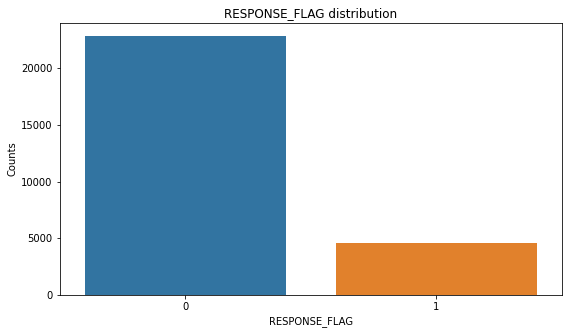

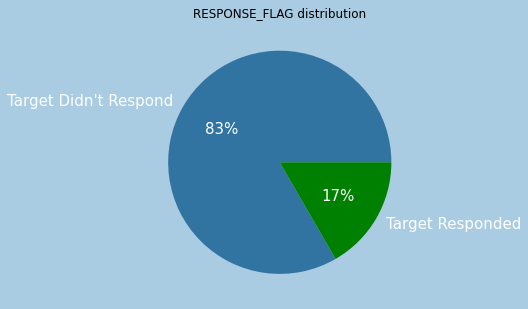


Values with Correlation Above 90%


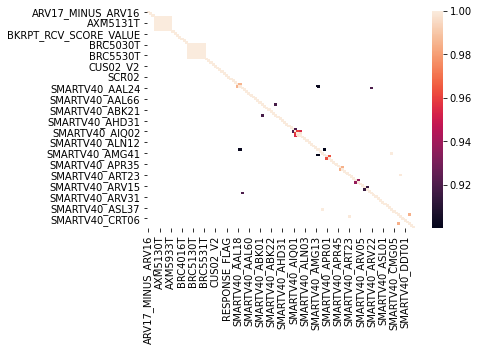


Missing Values Per Flag
0: 
 DEM08                10
SMARTV40_CMG04    19731
SMARTV40_CMG05    22349
SMARTV40_CRM01    22557
SMARTV40_CRN01    22228
SMARTV40_CRT01    18877
SMARTV40_CRT06    21674
dtype: int64
1: 
 DEM08                1
SMARTV40_CMG04    3874
SMARTV40_CMG05    4447
SMARTV40_CRM01    4508
SMARTV40_CRN01    4488
SMARTV40_CRT01    3651
SMARTV40_CRT06    4296
dtype: int64


In [0]:
# Exploring the Target

# Finding the Target variable
print(data.nunique()[data.nunique() == 2])

#let's visualise the distribution of flags
plt.figure(figsize=(9,5))
sns.countplot(data.RESPONSE_FLAG)
plt.title("RESPONSE_FLAG distribution")
plt.ylabel('Counts')
plt.show()

pie_chart = plt.figure(figsize=(5,8))
plt.pie(data.RESPONSE_FLAG.value_counts(normalize=True).mul(100).rename("RESPONSE_FLAG percentages"),
        labels=["Target Didn't Respond", 'Target Responded'], colors=['#3274a1', 'green'], 
         autopct='%1.0f%%', textprops={'color':"w", 'fontsize': 15})
plt.title("RESPONSE_FLAG distribution")
pie_chart.patch.set_facecolor('#A9CCE3')
plt.show()
print('\nValues with Correlation Above 90%')
sns.heatmap(data.corr().abs()[data.corr().abs() >= 0.90])
plt.show()
print()

print('Missing Values Per Flag')
print('0: \n', data[data.isna().sum()[data.isna().sum() > 0].keys()][data['RESPONSE_FLAG'] == 0].isna().sum())
print('1: \n', data[data.isna().sum()[data.isna().sum() > 0].keys()][data['RESPONSE_FLAG'] == 1].isna().sum())

# **Useful Functions**

In [0]:
# Useful Functions 
def model_performance(X0, X1, Y0, Y1, model):
    
    Y0_predict = model.predict(X0)
    Y1_predict = model.predict(X1)
    
    Y0_hat = model.predict_proba(X0)[:,1]
    Y1_hat = model.predict_proba(X1)[:,1]

    print('\nROC AUC Train', roc_auc_score(Y0, Y0_hat).round(3))
    print('ROC AUC Test', roc_auc_score(Y1,Y1_hat).round(3))
    print('-------------------------')
    print('\nClassification Report Train')
    print(classification_report(Y0,Y0_predict))
    print('-------------------------')
    print('\nClassification Report Test')
    print(classification_report(Y1,Y1_predict))
    print('-------------------------')

def logit_model_performance(X0, X1, Y0, Y1, model):
    
    Y0_hat = model.predict(X0)
    Y1_hat = model.predict(X1)
    Y0_class = np.where(Y0_hat>0.5, 1, 0)
    Y1_class = np.where(Y1_hat>0.5, 1, 0)

    print('\nROC AUC Train', roc_auc_score(Y0, Y0_hat).round(3))
    print('ROC AUC Test', roc_auc_score(Y1,Y1_hat).round(3))
    print('-------------------------')
    print('\nClassification Report Train')
    print(classification_report(Y0,Y0_class))
    print('-------------------------')
    print('\nClassification Report Test')
    print(classification_report(Y1,Y1_class))
    print('-------------------------')

# Outputs the columns that need to be dropped
def to_drop(dataset, corr_threshold):
  # Create correlation matrix
  corr_matrix = dataset.corr().abs()

  # Select upper triangle of correlation matrix
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

  # Find index of feature columns with correlation greater than corr_threshold
  drop = [column for column in upper.columns if any(upper[column] > corr_threshold)]

  drop = drop + ['ENCRYPTED_PIN','KEYID', 'XFC06', 'XFC07', 'SEGMENT_CODE',
                 'SMARTV40_CMG04', 'SMARTV40_CMG05', 'SMARTV40_CRM01', 
                 'SMARTV40_CRN01', 'SMARTV40_CRT01', 'SMARTV40_CRT06'
                 ]
  return drop

# Drops the outliers from the dataset 
def drop_outliers(dataset):
  for column in dataset.select_dtypes(exclude=['uint8', 'object']):
    data_column = dataset[column]
    outliers = data_column[((data_column - data_column.mean()) / data_column.std()).abs() > 3]
    if (len(outliers) < 20) and (len(outliers) != 0):
      dataset[column] = data_column[((data_column - data_column.mean()) / data_column.std()).abs() < 3]

# Outputs data ready for use
def clean_data (dataset, drop_columns):                         
  new_data = dataset.drop(columns=drop_columns)

  drop_outliers(new_data)

  new_data = pd.get_dummies(new_data,drop_first=True)

  new_data = new_data.dropna() # removes 11 rows. The missing values in DEM03.

  return new_data

In [0]:
#Let's setup the data for processing 
columns_dropped_1 = to_drop(data, 0.90) + ['SMARTV40_AAU19','SMARTV40_AAU20', 
                             'SMARTV40_AAU22','SMARTV40_ALE21',
                             'DEM03']

data_1 = clean_data(data,columns_dropped_1)

In [0]:
data_1.head()

,ARV17_MINUS_ARV16,AXM4970T,AXM4971T,AXM5030T,AXM5032T,AXM5130T,AXM5930T,AXM5932T,AXM5933T,AXM8131T,BKRPT_RCV_SCORE_VALUE,BRC4003T,BRC4012T,BRC4016T,BRC4970T,BRC4971T,BRC5030T,BRC5032T,BRC5130T,BRC5230T,BRC5530T,BRC8131T,CUNSAGE_V1,CUNSBAL_V1,CUNSINQ_V1,CUS02_V2,CUS07_REV120_V1,DEM05,EXP_ID,HOMEEQUITY_HEQ09,RESPONSE_FLAG,SCR02,SCR16,SEQNUM,SMARTV40_AAL01,SMARTV40_AAL18,SMARTV40_AAL24,SMARTV40_AAL25,SMARTV40_AAL27,SMARTV40_AAL60,...,DEM08_C,DEM08_D,DEM08_E,DEM08_F,DEM08_G,DEM08_H,DEM08_I,DEM08_J,DEM08_K,DEM08_L,DEM08_U,STATE_CD_AL,STATE_CD_AR,STATE_CD_AZ,STATE_CD_CA,STATE_CD_DC,STATE_CD_FL,STATE_CD_IN,STATE_CD_KY,STATE_CD_LA,STATE_CD_MA,STATE_CD_MD,STATE_CD_MI,STATE_CD_MO,STATE_CD_MS,STATE_CD_MT,STATE_CD_NC,STATE_CD_NE,STATE_CD_NJ,STATE_CD_NM,STATE_CD_NV,STATE_CD_NY,STATE_CD_OK,STATE_CD_PA,STATE_CD_SC,STATE_CD_SD,STATE_CD_TN,STATE_CD_TX,STATE_CD_VA,STATE_CD_WI
0,11108.0,7.0,10.0,9325.0,5506.0,33397.0,6850.0,137.0,100.0,1.0,473.0,0.0,23.0,6.0,8.0,14,13147.0,13703.0,21602.0,3723.0,8016.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,60,0.0,0,666.0,645.0,2813147.0,18.0,236569.0,87.0,5.0,51.0,2352.0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,182.0,7.0,14.0,26003.0,25970.0,34862.0,5695.0,189.0,189.0,3.0,213.0,0.0,8.0,20.0,8.0,15,15524.0,15491.0,24018.0,5582.0,6050.0,0.0,114.0,1105.0,0.0,0.0,0.0,0.0,60,0.0,0,635.0,665.0,2159430.0,10.0,34497.0,79.0,3.0,29.0,1020.0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,5342.0,7.0,14.0,7674.0,16485.0,30519.0,35108.0,503.0,558.0,0.0,494.0,0.0,3.0,18.0,8.0,14,11996.0,16722.0,22858.0,5586.0,7050.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,92,0.0,1,591.0,692.0,992375.0,8.0,31874.0,61.0,1.0,31.0,1217.0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,85.0,3.0,5.0,97.0,5996.0,57468.0,13488.0,213.0,193.0,19.0,1.0,0.0,23.0,24.0,7.0,12,1754.0,3005.0,27972.0,6801.0,7487.0,0.0,229.0,12472.0,51.0,1.0,1.0,33.0,62,46000.0,1,889.0,512.0,1958602.0,26.0,124274.0,587.0,5.0,188.0,3248.0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2245.0,5.0,9.0,1053.0,3664.0,66593.0,20189.0,83.0,84.0,24.0,109.0,0.0,24.0,24.0,7.0,13,5173.0,6871.0,22369.0,961.0,1234.0,0.0,21.0,2205.0,24.0,0.0,0.0,11.0,62,30000.0,1,945.0,605.0,1648761.0,32.0,97048.0,103.0,1.0,48.0,2324.0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Data Before


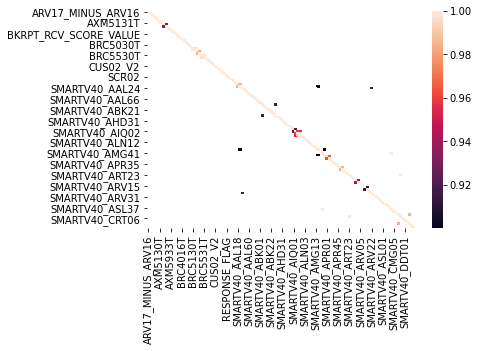

Data After


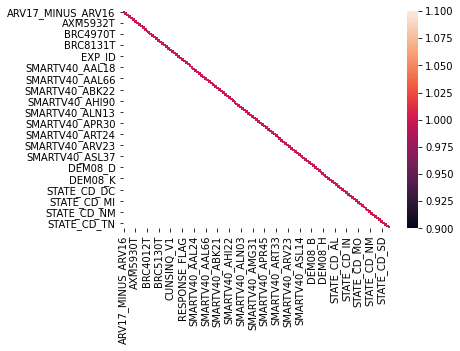

In [0]:
print('Data Before')
sns.heatmap(data.corr().abs()[data.corr().abs() > 0.90])
plt.show()

print('Data After')
sns.heatmap(data_1.corr().abs()[data_1.corr().abs() > 0.90])
plt.show()

# **Logistic regression**

In [0]:
# X and Y
Y = data_1["RESPONSE_FLAG"]
X = data_1.drop("RESPONSE_FLAG",axis=1)
X =  sm.add_constant(X)
#let's split

# ['EXP_ID', 'SCR16', 'SMARTV40_ABK21', 'SMARTV40_ABK23', 'SMARTV40_ARV18','SMARTV40_ARV32']

# ['CUNSINQ_V1', 'EXP_ID', 'SCR02', 'SMARTV40_ARV16', 'SMARTV40_ASL01','SMARTV40_ASL09']

# ['CUNSINQ_V1', 'EXP_ID', 'SCR02', 'SMARTV40_ARV16', 'SMARTV40_ASL01','SMARTV40_ASL09, ARV17_MINUS_ARV16']

X0, X1, Y0, Y1 = train_test_split(X, Y, test_size=0.25, random_state=42)

logit_model_1 = Logit(Y0, X0).fit()

logit_model_performance(X0, X1, Y0, Y1, logit_model_1)

         Current function value: 0.108375
         Iterations: 35

ROC AUC Train 0.958
ROC AUC Test 0.943
-------------------------

Classification Report Train
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     17128
           1       1.00      0.84      0.91      3421

    accuracy                           0.97     20549
   macro avg       0.98      0.92      0.95     20549
weighted avg       0.97      0.97      0.97     20549

-------------------------

Classification Report Test
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      5704
           1       1.00      0.82      0.90      1146

    accuracy                           0.97      6850
   macro avg       0.98      0.91      0.94      6850
weighted avg       0.97      0.97      0.97      6850

-------------------------


Maximum Likelihood optimization failed to converge. Check mle_retvals


In [0]:
logit_model_2 = LogisticRegression(C = 0.0001, class_weight = 'balanced',random_state=42).fit(X0,Y0)

model_performance(X0, X1, Y0, Y1, logit_model_2)


ROC AUC Train 0.672
ROC AUC Test 0.673
-------------------------

Classification Report Train
              precision    recall  f1-score   support

           0       0.89      0.54      0.67     17128
           1       0.22      0.67      0.33      3421

    accuracy                           0.56     20549
   macro avg       0.56      0.60      0.50     20549
weighted avg       0.78      0.56      0.61     20549

-------------------------

Classification Report Test
              precision    recall  f1-score   support

           0       0.89      0.55      0.68      5704
           1       0.22      0.65      0.33      1146

    accuracy                           0.57      6850
   macro avg       0.56      0.60      0.51      6850
weighted avg       0.78      0.57      0.62      6850

-------------------------


In [0]:
estimator = LogisticRegression(random_state=42)
selector =  RFE(estimator, 6, step=1)
selector.fit(X0, Y0)
n_feature_rankings = 1
best_features_logit = X0.columns[selector.ranking_ <= n_feature_rankings]

best_features_X0 = X0[best_features_logit]
best_features_X1 = X1[best_features_logit]
best_features_X = X[best_features_logit]

In [0]:
print('best_features_logit: ', best_features_logit, '\n')
logit_model_3 = LogisticRegression(C = 0.001, class_weight = 'balanced',random_state=42).fit(best_features_X0,Y0)
model_performance(best_features_X0, best_features_X1, Y0, Y1, logit_model_3)

best_features_logit:  Index(['EXP_ID', 'SCR16', 'SMARTV40_ABK21', 'SMARTV40_ABK23', 'SMARTV40_ARV18',
       'SMARTV40_ARV32'],
      dtype='object') 


ROC AUC Train 0.934
ROC AUC Test 0.934
-------------------------

Classification Report Train
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     17128
           1       1.00      0.84      0.91      3421

    accuracy                           0.97     20549
   macro avg       0.98      0.92      0.95     20549
weighted avg       0.97      0.97      0.97     20549

-------------------------

Classification Report Test
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      5704
           1       1.00      0.82      0.90      1146

    accuracy                           0.97      6850
   macro avg       0.98      0.91      0.94      6850
weighted avg       0.97      0.97      0.97      6850

-------------------------


In [0]:
param_logit={'class_weight':[None,'balanced'],
            'C':np.linspace(0,100,200)}

gridsearch = GridSearchCV(estimator=logit_model_3,
                        param_grid=param_logit,
                        cv=5,scoring='roc_auc',verbose=1,n_jobs= -1)
gridsearch.fit(best_features_X0, Y0)
best_model_params = gridsearch.best_params_

Fitting 5 folds for each of 400 candidates, totalling 2000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   33.1s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 1246 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 1796 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:  5.7min finished


In [0]:
best_model_params

{'C': 20.100502512562812, 'class_weight': None}

In [0]:
logit_model_4 = LogisticRegression(C = 20.100502512562812, class_weight = 'None',random_state=42).fit(best_features_X0,Y0)
model_performance(best_features_X0, best_features_X1, Y0, Y1, logit_model_4)


ROC AUC Train 0.934
ROC AUC Test 0.934
-------------------------

Classification Report Train
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     17128
           1       1.00      0.84      0.91      3421

    accuracy                           0.97     20549
   macro avg       0.98      0.92      0.95     20549
weighted avg       0.97      0.97      0.97     20549

-------------------------

Classification Report Test
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      5704
           1       1.00      0.82      0.90      1146

    accuracy                           0.97      6850
   macro avg       0.98      0.91      0.94      6850
weighted avg       0.97      0.97      0.97      6850

-------------------------


In [0]:
cv_scores=cross_val_score(logit_model_4,best_features_X,Y,cv=5,scoring="roc_auc")

In [0]:
print('cv_scores: ', cv_scores)
print('cv_score: ', np.mean(cv_scores).round(2))

cv_scores:  [0.93403844 0.9289047  0.93610645 0.93113727 0.92973423]
cv_score:  0.93


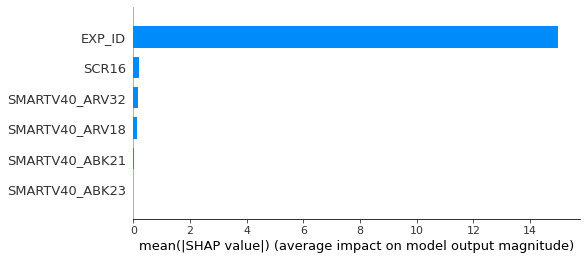

In [0]:
# Explaining the model with SHAP

shap_values = shap.LinearExplainer(logit_model_4, data_1[best_features_logit]).shap_values(best_features_X0)
shap.summary_plot(shap_values, best_features_X0, plot_type="bar")


# **Making A Decision Tree**


```
We will compare the results.
```






In [0]:
dt_1 = DecisionTreeClassifier(class_weight='balanced',max_depth=4,min_samples_leaf=10, random_state=42)
dt_1.fit(X0,Y0)
model_performance(X0, X1, Y0, Y1, dt_1)


ROC AUC Train 0.949
ROC AUC Test 0.94
-------------------------

Classification Report Train
              precision    recall  f1-score   support

           0       0.97      1.00      0.99     17128
           1       1.00      0.85      0.92      3421

    accuracy                           0.97     20549
   macro avg       0.99      0.92      0.95     20549
weighted avg       0.98      0.97      0.97     20549

-------------------------

Classification Report Test
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      5704
           1       1.00      0.84      0.91      1146

    accuracy                           0.97      6850
   macro avg       0.98      0.92      0.95      6850
weighted avg       0.97      0.97      0.97      6850

-------------------------


In [0]:
estimator = DecisionTreeClassifier(class_weight='balanced',max_depth=4,min_samples_leaf=10, random_state=42)
selector =  RFE(estimator, 4, step=1)
selector.fit(X0, Y0)
n_feature_rankings = 1
best_features_dt = X0.columns[selector.ranking_ <= n_feature_rankings]

dt_best_features_X0 = X0[best_features_dt]
dt_best_features_X1 = X1[best_features_dt]
dt_best_features_X = X[best_features_dt]

In [0]:
best_features_dt

Index(['CUNSINQ_V1', 'EXP_ID', 'SCR02', 'SMARTV40_ARV16', 'SMARTV40_ASL01',
       'SMARTV40_ASL09'],
      dtype='object')

In [0]:
param_dt={"max_depth":range(1,15),
          "class_weight":["balanced",None]        
            }
gs_dt=GridSearchCV(estimator=DecisionTreeClassifier(random_state=42), param_grid=param_dt,
                  scoring="roc_auc",cv=5, n_jobs= -1)
gs_dt.fit(X0,Y0)

In [0]:
gs_dt.best_params_

{'class_weight': 'balanced', 'max_depth': 4}

In [0]:
dt_2 = DecisionTreeClassifier(class_weight='balanced',max_depth=4,min_samples_leaf=300, random_state=42).fit(dt_best_features_X0,Y0)
model_performance(dt_best_features_X0, dt_best_features_X1, Y0, Y1, dt_2)


ROC AUC Train 0.95
ROC AUC Test 0.94
-------------------------

Classification Report Train
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     17128
           1       1.00      0.84      0.91      3421

    accuracy                           0.97     20549
   macro avg       0.98      0.92      0.95     20549
weighted avg       0.97      0.97      0.97     20549

-------------------------

Classification Report Test
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      5704
           1       1.00      0.82      0.90      1146

    accuracy                           0.97      6850
   macro avg       0.98      0.91      0.94      6850
weighted avg       0.97      0.97      0.97      6850

-------------------------


In [0]:
print("Mean 5-fold ROC AUC score for Tuned DT",np.mean(cross_val_score(estimator=dt_2,X=dt_best_features_X,y=Y,cv=5, scoring="roc_auc")).round(2))

Mean 5-fold ROC AUC score for Tuned DT 0.95


100%|===================| 40912/41098 [02:15<00:00]       

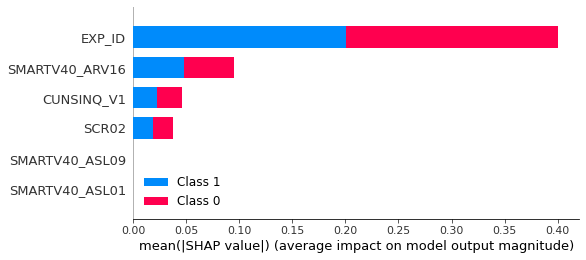

In [0]:
shap_values = shap.TreeExplainer(dt_2, data_1[best_features_dt]).shap_values(dt_best_features_X0)
shap.summary_plot(shap_values, dt_best_features_X0, plot_type="bar")

# **Random Forest Test**

In [0]:
rf_1 = RandomForestClassifier(class_weight=None,max_depth=4,min_samples_leaf=10, random_state=42, max_features=30).fit(X0,Y0)
model_performance(X0, X1, Y0, Y1, rf_1)


ROC AUC Train 0.956
ROC AUC Test 0.947
-------------------------

Classification Report Train
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     17128
           1       1.00      0.84      0.91      3421

    accuracy                           0.97     20549
   macro avg       0.98      0.92      0.95     20549
weighted avg       0.97      0.97      0.97     20549

-------------------------

Classification Report Test
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      5704
           1       1.00      0.82      0.90      1146

    accuracy                           0.97      6850
   macro avg       0.98      0.91      0.94      6850
weighted avg       0.97      0.97      0.97      6850

-------------------------


In [0]:
gs_rf=GridSearchCV(estimator=rf_1,
                   param_grid=param_dt, scoring="roc_auc", cv=3, n_jobs=-1)
gs_rf.fit(X0,Y0)

GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=4,
                                              max_features=30,
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=10,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=42,
                                        

In [0]:
gs_rf.best_params_

{'class_weight': 'balanced', 'max_depth': 9}

In [0]:
rf_2 = RandomForestClassifier(class_weight='balanced',max_depth=9, random_state=42).fit(X0,Y0)
model_performance(X0, X1, Y0, Y1, rf_2)


ROC AUC Train 0.989
ROC AUC Test 0.95
-------------------------

Classification Report Train
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     17128
           1       0.99      0.87      0.93      3421

    accuracy                           0.98     20549
   macro avg       0.98      0.94      0.96     20549
weighted avg       0.98      0.98      0.98     20549

-------------------------

Classification Report Test
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      5704
           1       0.98      0.83      0.90      1146

    accuracy                           0.97      6850
   macro avg       0.97      0.91      0.94      6850
weighted avg       0.97      0.97      0.97      6850

-------------------------


In [0]:
estimator = RandomForestClassifier(class_weight='balanced',max_depth=4,min_samples_leaf=10, random_state=42)
selector =  RFE(estimator, 6, step=1)
selector.fit(X0, Y0)
n_feature_rankings = 1
best_features_rf = X0.columns[selector.ranking_ <= n_feature_rankings]

rf_best_features_X0 = X0[best_features_rf]
rf_best_features_X1 = X1[best_features_rf]
rf_best_features_X = X[best_features_rf]

In [0]:
best_features_rf

Index(['CUNSINQ_V1', 'EXP_ID', 'SCR02', 'SMARTV40_ARV16', 'SMARTV40_ASL01',
       'SMARTV40_ASL09'],
      dtype='object')

In [0]:
rf_3 = RandomForestClassifier(class_weight=None,max_depth=4,min_samples_leaf=10, random_state=42).fit(rf_best_features_X0,Y0)
model_performance(rf_best_features_X0, rf_best_features_X1, Y0, Y1, rf_3)


ROC AUC Train 0.954
ROC AUC Test 0.942
-------------------------

Classification Report Train
              precision    recall  f1-score   support

           0       0.97      1.00      0.99     17128
           1       1.00      0.85      0.92      3421

    accuracy                           0.97     20549
   macro avg       0.99      0.92      0.95     20549
weighted avg       0.98      0.97      0.97     20549

-------------------------

Classification Report Test
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      5704
           1       1.00      0.84      0.91      1146

    accuracy                           0.97      6850
   macro avg       0.98      0.92      0.95      6850
weighted avg       0.97      0.97      0.97      6850

-------------------------


In [0]:
print("Mean 5-fold ROC AUC score for Tuned RF",np.mean(cross_val_score(estimator=rf_3,X=rf_best_features_X,y=Y,cv=5, scoring="roc_auc")).round(2))

Mean 5-fold ROC AUC score for Tuned RF 0.95


In [0]:
shap_values = shap.TreeExplainer(rf_3, data_1[best_features_rf]).shap_values(rf_best_features_X0)
shap.summary_plot(shap_values, rf_best_features_X0, plot_type="bar")
# three hours?

# **Gradient Boosting Test**

In [0]:
gb_1 = GradientBoostingClassifier(loss= 'exponential',max_depth=3,min_samples_leaf=800, random_state=42, 
                                   n_estimators = 250, subsample = 0.9, criterion='friedman_mse',
                                   ccp_alpha=0.00,learning_rate=0.05, min_samples_split=18490,
                                   min_weight_fraction_leaf=0.01).fit(X0,Y0)

model_performance(X0, X1, Y0, Y1, gb_1)


ROC AUC Train 0.961
ROC AUC Test 0.948
-------------------------

Classification Report Train
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     17128
           1       1.00      0.84      0.91      3421

    accuracy                           0.97     20549
   macro avg       0.98      0.92      0.95     20549
weighted avg       0.97      0.97      0.97     20549

-------------------------

Classification Report Test
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      5704
           1       1.00      0.82      0.90      1146

    accuracy                           0.97      6850
   macro avg       0.98      0.91      0.94      6850
weighted avg       0.97      0.97      0.97      6850

-------------------------


In [0]:
param_gb = { "loss" : ['deviance', 'exponential'],
            "max_depth":range(5,10)
            }

gs_gb = GridSearchCV(estimator=GradientBoostingClassifier(random_state=42),
                   param_grid=param_gb, scoring="roc_auc", cv=3, n_jobs=-1)
gs_gb.fit(X0,Y0)

In [0]:
gs_gb.best_params_

In [0]:
gb_2 = GradientBoostingClassifier(loss= 'exponential',max_depth=3,min_samples_leaf=900, random_state=42, 
                                   n_estimators = 250).fit(X0,Y0)

model_performance(X0, X1, Y0, Y1, gb_2)


ROC AUC Train 0.985
ROC AUC Test 0.95
-------------------------

Classification Report Train
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     17128
           1       1.00      0.84      0.91      3421

    accuracy                           0.97     20549
   macro avg       0.98      0.92      0.95     20549
weighted avg       0.97      0.97      0.97     20549

-------------------------

Classification Report Test
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      5704
           1       1.00      0.82      0.90      1146

    accuracy                           0.97      6850
   macro avg       0.98      0.91      0.94      6850
weighted avg       0.97      0.97      0.97      6850

-------------------------


In [0]:
estimator = GradientBoostingClassifier(class_weight='balanced',max_depth=4,min_samples_leaf=10, random_state=42)
selector =  RFE(estimator, 6, step=1)
selector.fit(X0, Y0)
n_feature_rankings = 1
best_features_gb = X0.columns[selector.ranking_ <= n_feature_rankings]

gb_best_features_X0 = X0[best_features_gb]
gb_best_features_X1 = X1[best_features_gb]
gb_best_features_X = X[best_features_gb]

{'loss': 'exponential', 'max_depth': 5, 'min_samples_leaf': 10}

In [0]:
best_features_gb

In [0]:
gb_3 = GradientBoostingClassifier(loss= 'exponential',max_depth=3,min_samples_leaf=800, random_state=42, 
                                   n_estimators = 250, subsample = 0.9, criterion='friedman_mse',
                                   ccp_alpha=0.00,learning_rate=0.05, min_samples_split=18490,
                                   min_weight_fraction_leaf=0.01).fit(gb_best_features_X0,Y0)

model_performance(gb_best_features_X0, gb_best_features_X1, Y0, Y1, gb_3)

In [0]:
print("Mean 5-fold ROC AUC score for Tuned GB",np.mean(cross_val_score(estimator=gb_3,X=X,y=Y,cv=5, scoring="roc_auc")).round(2))

In [0]:
shap_values = shap.TreeExplainer(gb_1, data_1[best_features_dt]).shap_values(dt_best_features_X0)
shap.summary_plot(shap_values, dt_best_features_X0, plot_type="bar")
# Let's try using the features recommended by the DT model as replacements.

# **Final Model**

In [0]:
print(to_drop(data, 0.5))
print(to_drop(data, 0.8))

['AXM4971T', 'AXM5032T', 'AXM5130T', 'AXM5131T', 'AXM5930T', 'AXM5931T', 'AXM5932T', 'AXM5933T', 'AXM8131T', 'BRC4970T', 'BRC4971T', 'BRC5030T', 'BRC5032T', 'BRC5130T', 'BRC5131T', 'BRC5230T', 'BRC5231T', 'BRC5530T', 'BRC5531T', 'RESPONSE_FLAG', 'SCR16', 'SEQNUM', 'SMARTV40_AAL19', 'SMARTV40_AAL27', 'SMARTV40_AAL60', 'SMARTV40_AAL61', 'SMARTV40_AAL63', 'SMARTV40_ABK01', 'SMARTV40_ABK05', 'SMARTV40_ABK18', 'SMARTV40_ABK22', 'SMARTV40_ABK33', 'SMARTV40_AHD11', 'SMARTV40_AHI22', 'SMARTV40_AHI46', 'SMARTV40_AIN17', 'SMARTV40_AIQ02', 'SMARTV40_AIQ04', 'SMARTV40_AIQ05', 'SMARTV40_AIQ07', 'SMARTV40_ALN13', 'SMARTV40_ALN14', 'SMARTV40_AMG14', 'SMARTV40_AMG46', 'SMARTV40_APR04', 'SMARTV40_APR24', 'SMARTV40_APR45', 'SMARTV40_ART02', 'SMARTV40_ART07', 'SMARTV40_ART17', 'SMARTV40_ART18', 'SMARTV40_ART24', 'SMARTV40_ART33', 'SMARTV40_ARV01', 'SMARTV40_ARV03', 'SMARTV40_ARV05', 'SMARTV40_ARV16', 'SMARTV40_ARV17', 'SMARTV40_ARV18', 'SMARTV40_ARV22', 'SMARTV40_ARV23', 'SMARTV40_ARV31', 'SMARTV40_ARV32

In [0]:
#Let's setup the data for processing
columns_dropped_2 = to_drop(data, 0.8)

data_2 = clean_data(data,columns_dropped_2)
# X and Y
Y_final = data_2["RESPONSE_FLAG"]
X_final = data_2.drop("RESPONSE_FLAG",axis=1)
X_final =  sm.add_constant(X_final)

# Feature Engineering
# ['EXP_ID', 'SCR16', 'SMARTV40_ABK21', 'SMARTV40_ABK23', 'SMARTV40_ARV18','SMARTV40_ARV32']

# ['CUNSINQ_V1', 'EXP_ID', 'SCR02', 'SMARTV40_ARV16', 'SMARTV40_ASL01','SMARTV40_ASL09']

# ['CUNSINQ_V1', 'EXP_ID', 'SCR02', 'SMARTV40_ARV16', 'SMARTV40_ASL01','SMARTV40_ASL09', ARV17_MINUS_ARV16]

# X_final['Diff_2'] = (data_2['ARV17_MINUS_ARV16'].apply(lambda x: 0 if x > 0 else 1)) * data_2['ARV17_MINUS_ARV16'].abs()
# X_final['Diff_1'] = data_2.EXP_ID.apply(lambda x: 0 if x==60 else 1) * data_2.EXP_ID
# No difference made for Gradient Boosting model

#let's split
X0_final, X1_final, Y0_final, Y1_final = train_test_split(X_final, Y_final, test_size=0.25, random_state=42)

min_max_scaler = preprocessing.MinMaxScaler().fit(X0_final)
scaler = preprocessing.StandardScaler().fit(X0_final)

In [0]:
gb_final = GradientBoostingClassifier(loss= 'exponential',max_depth=3, random_state=42, 
                                      n_estimators = 40,learning_rate=0.04, 
                                      min_samples_leaf=900).fit(scaler.transform(X0_final),Y0_final)

model_performance(scaler.transform(X0_final),scaler.transform(X1_final),Y0_final, Y1_final, gb_final)


ROC AUC Train 0.958
ROC AUC Test 0.953
-------------------------

Classification Report Train
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     17137
           1       1.00      0.84      0.91      3417

    accuracy                           0.97     20554
   macro avg       0.98      0.92      0.95     20554
weighted avg       0.97      0.97      0.97     20554

-------------------------

Classification Report Test
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      5701
           1       1.00      0.83      0.91      1151

    accuracy                           0.97      6852
   macro avg       0.98      0.92      0.95      6852
weighted avg       0.97      0.97      0.97      6852

-------------------------


In [0]:
print("Mean 5-fold ROC AUC score for Tuned GB",np.mean(cross_val_score(estimator=gb_final,X=scaler.transform(X_final),
                                                                       y=Y_final,cv=5, scoring="roc_auc")).round(3))

Mean 5-fold ROC AUC score for Tuned GB 0.951


# **Model Interpretation**

In [0]:
shap_values = shap.TreeExplainer(gb_final, data_2).shap_values(X0_final)
# shap.dependence_plot("EXP_ID", shap_values, X0_final)
shap.force_plot()


ROC AUC Train 0.938
ROC AUC Test 0.935
-------------------------

Classification Report Train
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     17137
           1       0.98      0.85      0.91      3417

    accuracy                           0.97     20554
   macro avg       0.97      0.92      0.95     20554
weighted avg       0.97      0.97      0.97     20554

-------------------------

Classification Report Test
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      5701
           1       0.98      0.84      0.90      1151

    accuracy                           0.97      6852
   macro avg       0.97      0.92      0.94      6852
weighted avg       0.97      0.97      0.97      6852

-------------------------


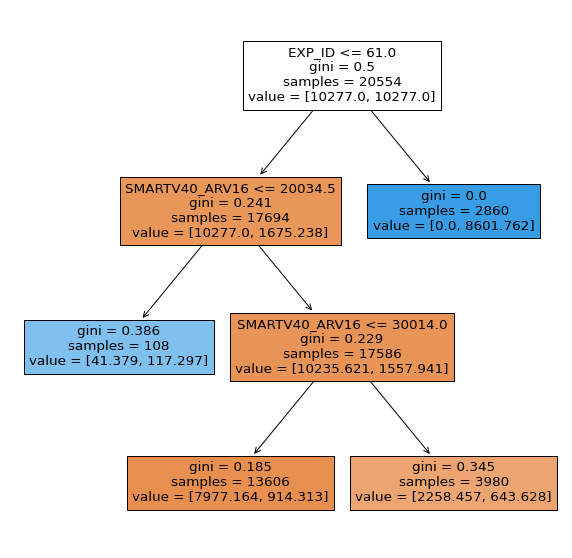

In [0]:
estimator = DecisionTreeClassifier(class_weight='balanced',max_depth=3,min_samples_leaf=104, random_state=42)
selector =  RFE(estimator, 4, step=1)
selector.fit(X0_final, Y0_final)
n_feature_rankings = 1
best_features_dt = X0_final.columns[selector.ranking_ <= n_feature_rankings]

dt_best_features_X0 = X0_final[best_features_dt]
dt_best_features_X1 = X1_final[best_features_dt]
dt_best_features_X = X_final[best_features_dt]


dt_2 = DecisionTreeClassifier(class_weight='balanced',max_depth=3,min_samples_leaf=104, random_state=42).fit(dt_best_features_X0,Y0_final)
model_performance(dt_best_features_X0, dt_best_features_X1, Y0_final, Y1_final, dt_2)
plt.figure(figsize=(10, 10))
plot_tree(dt_2,feature_names= dt_best_features_X.columns, filled=True)
# plt.savefig('my.png')
plt.show()

In [0]:
print('Counts: ', data.groupby('RESPONSE_FLAG')['EXP_ID'].count(), '\n')
print('Means: ', data.groupby('RESPONSE_FLAG')['EXP_ID'].mean())

Counts:  RESPONSE_FLAG
0    22850
1     4570
Name: EXP_ID, dtype: int64 

Means:  RESPONSE_FLAG
0    60.00000
1    74.14267
Name: EXP_ID, dtype: float64


In [0]:
data_2.EXP_ID.value_counts()

60    23589
62      678
66      612
72      556
92      436
96      423
84      373
88      360
76      209
68      170
Name: EXP_ID, dtype: int64

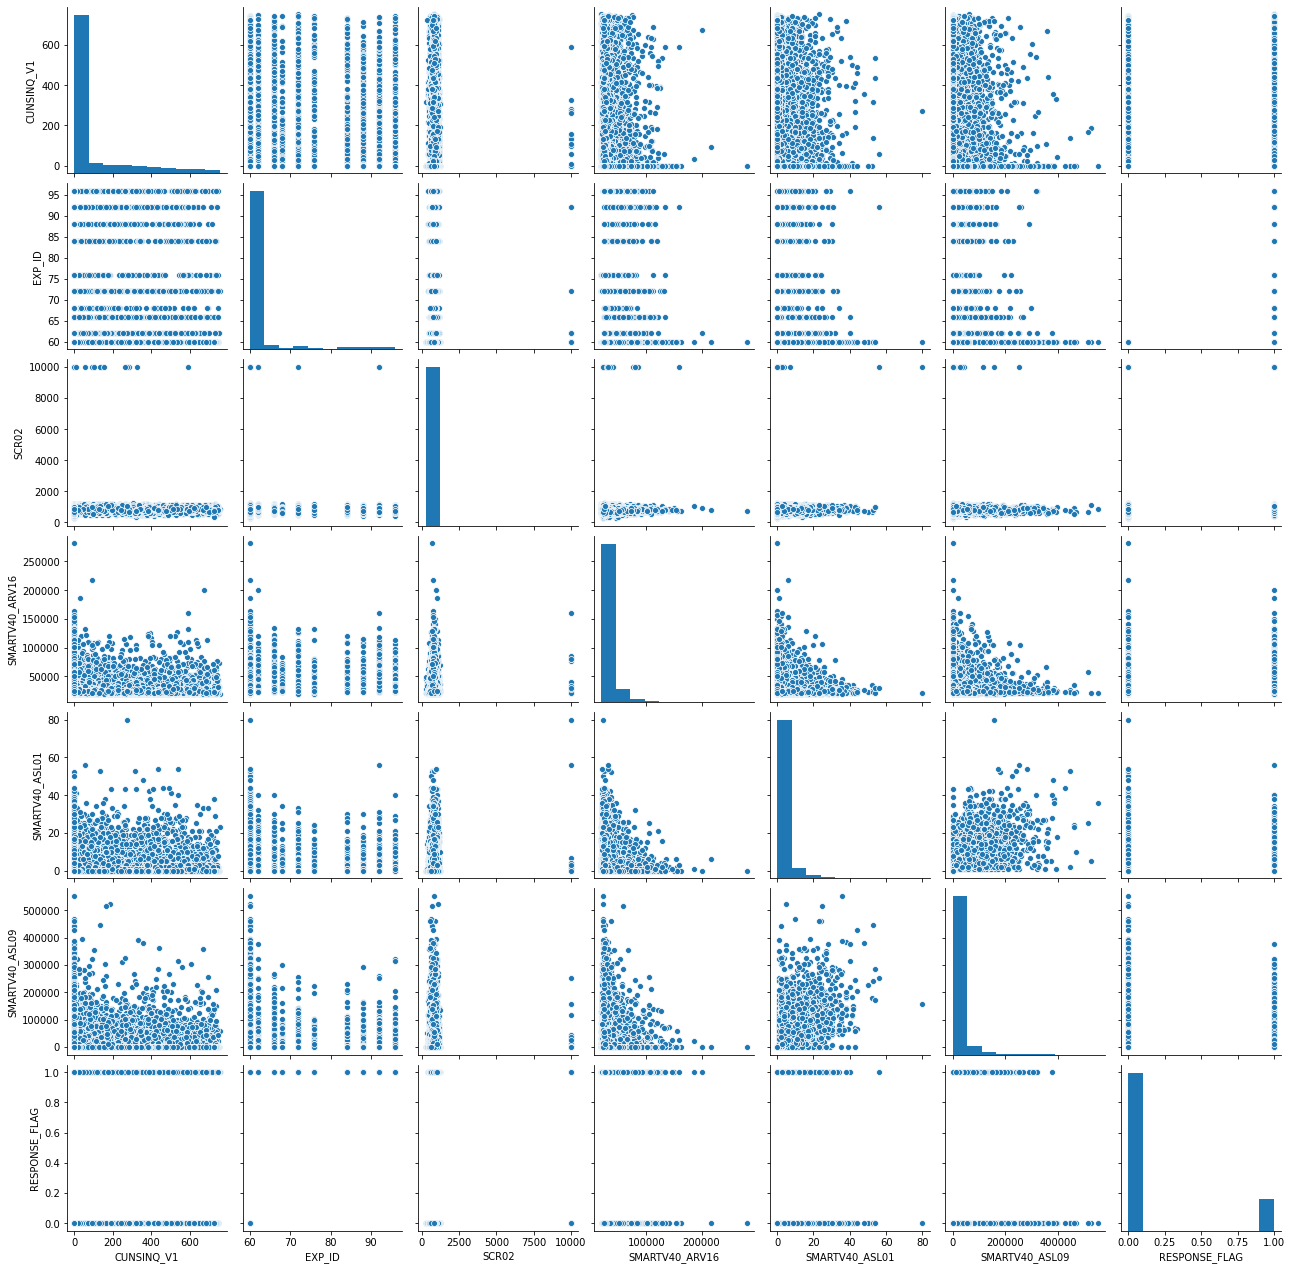

In [0]:
sns.pairplot(data_2[['CUNSINQ_V1', 'EXP_ID', 'SCR02', 'SMARTV40_ARV16', 
                     'SMARTV40_ASL01','SMARTV40_ASL09', 'RESPONSE_FLAG']])
plt.show()

In [0]:
print(logit_model_1.summary())

                           Logit Regression Results                           
Dep. Variable:          RESPONSE_FLAG   No. Observations:                20549
Model:                          Logit   Df Residuals:                    20421
Method:                           MLE   Df Model:                          127
Date:                Fri, 15 May 2020   Pseudo R-squ.:                  0.7593
Time:                        23:31:26   Log-Likelihood:                -2227.0
converged:                      False   LL-Null:                       -9252.4
Covariance Type:            nonrobust   LLR p-value:                     0.000
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  -745.4227   5.27e+04     -0.014      0.989   -1.04e+05    1.03e+05
ARV17_MINUS_ARV16     -3.988e-06   9.91e-06     -0.403      0.687   -2.34e-05    1.54e-05
AXM4970T

In [0]:
print(logit_model_1.get_margeff().summary())

        Logit Marginal Effects       
Dep. Variable:          RESPONSE_FLAG
Method:                          dydx
At:                           overall
                           dy/dx    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
ARV17_MINUS_ARV16     -9.924e-08   2.47e-07     -0.403      0.687   -5.82e-07    3.84e-07
AXM4970T                  0.0009      0.001      0.724      0.469      -0.001       0.003
AXM4971T              -8.706e-05      0.001     -0.119      0.905      -0.002       0.001
AXM5030T              -5.348e-08      6e-08     -0.892      0.372   -1.71e-07     6.4e-08
AXM8131T                 -0.0002      0.000     -0.899      0.368      -0.001       0.000
BKRPT_RCV_SCORE_VALUE -1.971e-05   1.45e-05     -1.355      0.175   -4.82e-05     8.8e-06
BRC4003T                  0.0006      0.001      0.815      0.415      -0.001       0.002
BRC4012T                 -0.0003      

# **ROC Curve**

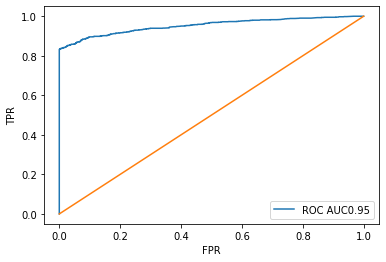

In [0]:
FPR, TPR, thresholds = roc_curve(Y1_final, gb_final.predict_proba(scaler.transform(X1_final))[:,1])
#plotting ROC AUC for Logistic Regression
plt.plot(FPR, TPR, label=f"ROC AUC{roc_auc_score(Y1_final,gb_final.predict_proba(scaler.transform(X1_final))[:,1]).round(2)}")
plt.plot([0,1],[0,1])
plt.legend(loc="lower right")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()

# **Gain Curve**

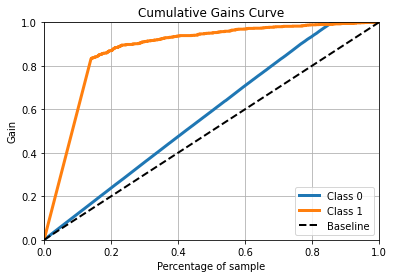

In [0]:
skplt.metrics.plot_cumulative_gain(Y1_final,gb_final.predict_proba(scaler.transform(X1_final)))
plt.show()

# **Lift Curve**

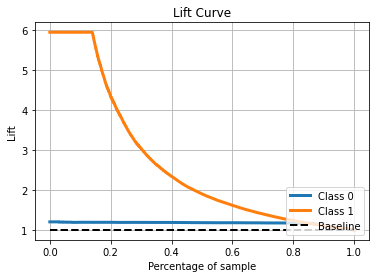

In [0]:
skplt.metrics.plot_lift_curve(Y1_final,gb_final.predict_proba(scaler.transform(X1_final)))
plt.show()

# **Model with a Higher recall for 1s**

In [0]:
gb_high_Target_recall = GradientBoostingClassifier(loss= 'exponential',max_depth=3, random_state=42, 
                                      n_estimators = 40,learning_rate=0.04, 
                                      min_samples_leaf=900).fit(scaler.transform(X0_final),Y0_final)

Y0_predict_gb = gb_high_Target_recall.predict(scaler.transform(X0_final))
Y1_predict_gb = gb_high_Target_recall.predict(scaler.transform(X1_final))

Y0_hat_gb = gb_high_Target_recall.predict_proba(scaler.transform(X0_final))[:,1]
Y1_hat_gb = gb_high_Target_recall.predict_proba(scaler.transform(X1_final))[:,1]

threshold = 0.0859

Y0_class = np.where(Y0_hat_gb>threshold, 1, 0)
Y1_class = np.where(Y1_hat_gb>threshold, 1, 0)

print('\nROC AUC Train', roc_auc_score(Y0_final, Y0_hat_gb).round(3))
print('ROC AUC Test', roc_auc_score(Y1_final,Y1_hat_gb).round(3))
print('-------------------------')
print('\nClassification Report Train')
print(classification_report(Y0_final,Y0_class))
print('-------------------------')
print('\nClassification Report Test')
print(classification_report(Y1_final,Y1_class))
print('-------------------------')


ROC AUC Train 0.958
ROC AUC Test 0.953
-------------------------

Classification Report Train
              precision    recall  f1-score   support

           0       0.97      0.98      0.97     17137
           1       0.88      0.86      0.87      3417

    accuracy                           0.96     20554
   macro avg       0.93      0.92      0.92     20554
weighted avg       0.96      0.96      0.96     20554

-------------------------

Classification Report Test
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      5701
           1       0.87      0.85      0.86      1151

    accuracy                           0.95      6852
   macro avg       0.92      0.91      0.92      6852
weighted avg       0.95      0.95      0.95      6852

-------------------------
